# Readme

# Setup

In [340]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import time
import random
import pickle
import json
import itertools
import importlib
import os
import seaborn as sns

from scipy.interpolate import interp1d

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [341]:
import sys
sys.path.append ('functions')

import functions as mf
importlib.reload(mf) 

from rnn_module import AmmoniaRNN

In [342]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [343]:
pd.set_option("display.max_columns", None)

# Model

**We do not use the 'AmmoniaRNN' module from ./functions/rnn_module.py. We need to modify it to get the latent variables in the ouput.**

In [344]:
class AmmoniaRNN(nn.Module):
    
    def __init__(self, 
                 input_size, 
                 output_size, 
                 hidden_size, 
                 num_layers,
                 nonlinearity, 
                 bidirectional,
                 mlp,
                 with_embeddings = False, cat_dims = None, embedding_dims = None):
        
        super(AmmoniaRNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.nonlinearity = nonlinearity
        self.bidirectional = bidirectional
        self.mlp = mlp
        self.with_embeddings = with_embeddings

        D = 1 + 1 * bidirectional
        
        if (self.with_embeddings):
       
            # Create an embedding layer for each categorical variable
            self.embeddings = nn.ModuleList([
                nn.Embedding(num_embeddings = cat_dim, embedding_dim = embed_dim)
                for cat_dim, embed_dim in zip(cat_dims, embedding_dims)
            ])
            
            input_size = input_size - len(cat_dims) + sum(embedding_dims)           
        
        # RNN layer
        self.rnn = nn.RNN(input_size, 
                          hidden_size, 
                          num_layers = num_layers,
                          nonlinearity = nonlinearity, 
                          bidirectional = bidirectional)    
        
        # Fully connected layer(s)
        if self.mlp:
            self.fc1 = nn.Linear(hidden_size * D, 6)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(6, output_size)
        else:
            self.fc = nn.Linear(hidden_size * D, output_size)

    def forward(self, x):

        if (self.with_embeddings):

            x_continuous = x[0]
            x_categoricals = x[1]
            
            # Get embeddings for each categorical variable
            x_embeds = [embed(x_cat) for embed, x_cat in zip(self.embeddings, x_categoricals)]
            
            # Concatenate all embeddings with the continuous features
            x = torch.cat([x_continuous] + x_embeds, dim = -1)
        
        # Forward pass through RNN
        h1, _ = self.rnn(x)

        if self.mlp:
            h2 = self.fc1(h1)
            h3 = self.relu(h2)
            out = self.fc2(h3)
        else:
            out = self.fc(h1)
        
        return [out, x_embeds, h1, h2]

In [345]:
num_layers = 1
nonlinearity = "relu"
bidirectional = True
mlp = True
with_embeddings = True
response = "delta_e.cum"
hidden_size = 512 

if (with_embeddings):
    #data = data_embeddings
    cat_dims = [5, 3, 2]  
    embedding_dims = [10, 9, 8]  
    input_size = 13
    
output_size = 1
if (response == "e.cum and delta_e.cum"): output_size = 2

In [346]:
torch.manual_seed(1)
model = AmmoniaRNN(input_size = input_size, 
                   output_size = output_size, 
                   hidden_size = hidden_size, 
                   nonlinearity = nonlinearity,
                   num_layers = num_layers,
                   bidirectional = bidirectional,
                   mlp = mlp,
                   with_embeddings = with_embeddings, 
                   cat_dims = cat_dims, 
                   embedding_dims = embedding_dims).to(DEVICE)

In [347]:
filename_model = f'results/10_2_predictions_on_scenarios_with_data_augmentation/final_model'

# Predictions on scenarios

In [348]:
data_scenarios = pd.read_csv("../data/processed_data/scenarios_rnn.csv")

In [349]:
data_scenarios = data_scenarios.drop(['Unnamed: 0'], axis = 1)

In [350]:
data_scenarios = data_scenarios[data_scenarios['seq'].isin ([6])]

In [351]:
data_scenarios.head (2)

scenario  pmid       strategy  group_temp  group_wind  group_rain  ct  \
41472         1  2001  Incorporation           1           1           1   6   
41473         1  2001  Incorporation           1           1           1  12   

       dt   air.temp   wind.2m  rain.rate  tan.app  app.mthd  app.rate  \
41472   6  11.066667  2.300000        0.0     36.7         0      18.7   
41473   6   9.400000  1.966667        0.0     36.7         0      18.7   

       man.dm  man.ph  man.source  incorp  t.incorp  seq  ct_shift  
41472     3.8     7.5           0       1         0    6         0  
41473     3.8     7.5           0       1         0    6         6

In [352]:
pmids_scenarios = data_scenarios['pmid'].unique()

In [353]:
seq = data_scenarios['seq'].unique()

In [354]:
data_scenarios['prediction_ecum'] = None
data_scenarios['prediction_delta_ecum'] = None
    
with torch.no_grad():

    all_predictions = torch.empty(0).to(DEVICE)
    all_x_embeds = torch.empty(0).to(DEVICE)
    all_h1 = torch.empty(0).to(DEVICE)
    all_h2 = torch.empty(0).to(DEVICE)

    model.load_state_dict(torch.load(filename_model + '.pth', weights_only = True, map_location=torch.device('cpu')))
        
    for i in pmids_scenarios:

        x = mf.generate_tensors_predictors (data_scenarios, i, with_embeddings, device = DEVICE)

        model_outputs = model (x)
        
        y = model_outputs[0]
        all_predictions = torch.cat ((all_predictions, y.squeeze()), 0)
        
        x_embeds = model_outputs[1]
        x_embeds = torch.cat (x_embeds, 1)
        all_x_embeds = torch.cat ((all_x_embeds, x_embeds.squeeze()), 0)

        h1 = model_outputs[2]
        all_h1 = torch.cat ((all_h1, h1.squeeze()), 0)

        h2 = model_outputs[3]
        all_h2 = torch.cat ((all_h2, h2.squeeze()), 0)


    data_scenarios['prediction_delta_ecum'] = all_predictions.to("cpu").detach()

data_scenarios['prediction_ecum'] = data_scenarios.groupby('pmid')['prediction_delta_ecum'].cumsum()

In [355]:
data_scenarios.head (2)

scenario  pmid       strategy  group_temp  group_wind  group_rain  ct  \
41472         1  2001  Incorporation           1           1           1   6   
41473         1  2001  Incorporation           1           1           1  12   

       dt   air.temp   wind.2m  rain.rate  tan.app  app.mthd  app.rate  \
41472   6  11.066667  2.300000        0.0     36.7         0      18.7   
41473   6   9.400000  1.966667        0.0     36.7         0      18.7   

       man.dm  man.ph  man.source  incorp  t.incorp  seq  ct_shift  \
41472     3.8     7.5           0       1         0    6         0   
41473     3.8     7.5           0       1         0    6         6   

       prediction_ecum  prediction_delta_ecum  
41472         1.962584               1.962584  
41473         1.995975               0.033392

In [356]:
data_scenarios["app.mthd"] = data_scenarios["app.mthd"].astype(str)
data_scenarios["app.mthd"] = data_scenarios["app.mthd"].replace({
    "0": "bc", "1": "bsth", "2": "os", "3": "ts", "4": "cs"
})

data_scenarios["man.source"] = data_scenarios["man.source"].astype(str)
data_scenarios["man.source"] = data_scenarios["man.source"].replace({
    "0": "pig", "1": "cat"
})

data_scenarios["incorp"] = data_scenarios["incorp"].astype(str)
data_scenarios["incorp"] = data_scenarios["incorp"].replace({
    "0": "none", "1": "shallow", "2": "deep"
})

# At t = 6

In [486]:
data_scenarios_with_h = pd.concat(
    [data_scenarios.reset_index(drop=True),
     pd.DataFrame (all_x_embeds).reset_index(drop=True),
     pd.DataFrame (all_h2).reset_index(drop=True),
     pd.DataFrame (all_h1).reset_index(drop=True)],
    axis = 1)

In [487]:
data_scenarios_with_h = data_scenarios_with_h.loc[
    data_scenarios_with_h.groupby('pmid')['ct'].transform('min') == data_scenarios_with_h['ct']
]

In [488]:
data_scenarios_with_h.head (2)

scenario  pmid       strategy  group_temp  group_wind  group_rain  ct  dt  \
0          1  2001  Incorporation           1           1           1   6   6   
12         1  2002      Broadcast           1           1           1   6   6   

     air.temp  wind.2m  rain.rate  tan.app app.mthd  app.rate  man.dm  man.ph  \
0   11.066667      2.3        0.0     36.7       bc      18.7     3.8     7.5   
12  11.066667      2.3        0.0     36.7       bc      18.7     3.8     7.5   

   man.source   incorp  t.incorp  seq  ct_shift  prediction_ecum  \
0         pig  shallow         0    6         0         1.962584   
12        pig     none      1000    6         0         6.223275   

    prediction_delta_ecum         0         1         2         3         4  \
0                1.962584 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   
12               6.223275 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   

           5         6        7         8         9        10        11  \
0  -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.839846 -0.462206   
12 -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.395510 -0.540698   

          12        13        14        15        16        17        18  \
0  -1.322526  0.090657 -0.147480  0.778217  1.245540  0.851135 -0.951186   
12 -0.143261  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280   

          19        20       21        22       23        24        25  \
0   0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   
12  0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   

          26          0         1         2          3          4          5  \
0   0.514588  -5.626672 -3.087967 -4.091456  20.286472 -19.480667  -0.775877   
12  0.514588 -10.969412 -2.913736 -8.871185  26.696453  -5.388247  14.225320   

            0         1         2         3         4         5         6  \
0    3.095272  0.000000  0.000000  4.818062  1.456873  2.571879  0.000000   
12  10.849297  2.908804  3.970929  0.729963  4.496194  8.913378  4.352267   

           7         8    9        10        11        12        13        14  \
0   3.370545  2.040388  0.0  2.092163  1.712083  2.310251  0.000000  5.453723   
12  0.000000  0.000000  0.0  0.000000  0.000000  2.559652  4.295677  0.000000   

     15        16        17        18        19   20        21        22  \
0   0.0  0.000000  1.297186  0.000000  5.576601  0.0  0.000000  0.716901   
12  0.0  4.510935  0.000000  1.479421  0.000000  0.0  6.094409  0.000000   

          23        24        25   26        27         28        29   30  \
0   5.147791  3.037886  1.730061  0.0  0.682911   0.000000  2.551709  0.0   
12  0.000000  0.000000  4.767105  0.0  0.206006  14.634515  0.000000  0.0   

          31   32         33        34   35        36   37        38  \
0   1.802823  0.0   0.000000  0.510401  0.0  2.919871  0.0  0.000000   
12  0.000000  0.0  10.609422  0.000000  0.0  0.000000  0.0  1.214703   

          39        40        41        42        43        44        45  \
0   3.711581  2.933553  0.850299  0.000000  4.780388  4.569801  1.099273   
12  0.000000  2.040895  1.978338  4.309175  0.000000  0.000000  0.000000   

         46        47        48   49   50   51        52   53        54  \
0   0.00000  0.000000  3.704037  0.0  0.0  0.0  5.890944  0.0  0.000000   
12  6.50327  3.270604  0.000000  0.0  0.0  0.0  0.924025  0.0  0.343387   

          55       56        57        58        59        60   61        62  \
0   3.472017  3.18103  1.345339  6.266679  0.000000  0.000000  0.0  0.000000   
12  0.000000  0.00000  0.000000  7.315651  2.570816  2.538459  0.0  3.656111   

          63       64   65   66         67        68        69   70        71  \
0   0.000000  1.07439  0.0  0.0   0.000000  5.973127  0.000000  0.0  2.080787   
12  3.557507  8.20753  0.0  0.0  12.023853  0.000000  8.746062  0.0  0.000000   

          72        73        74        75        76        

## PCA on x_embeds

### Sans le temps et la météo

In [489]:
data_scenarios_with_h.iloc[:, np.r_[-1072:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].head()

air.temp  wind.2m  rain.rate  tan.app  app.rate  man.dm  man.ph  \
0   11.066667      2.3        0.0     36.7      18.7     3.8     7.5   
12  11.066667      2.3        0.0     36.7      18.7     3.8     7.5   
24  11.066667      2.3        0.0     36.7      18.7     3.8     7.5   
36  11.066667      2.3        0.0     36.7      18.7     3.8     7.5   
48  11.066667      2.3        0.0     36.7      18.7     3.8     7.5   

    t.incorp         0         1         2         3         4         5  \
0          0 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096 -1.012481   
12      1000 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096 -1.012481   
24      1000 -0.694728 -0.124331 -0.100394  2.166680  0.364520  1.307028   
36      1000 -0.661530  0.056595  2.186193  0.019265  0.150248 -0.403367   
48      1000  1.346063  0.821633 -0.445946  1.066994  1.431368 -0.093620   

           6         7         8         9        10        11        12  \
0  -0.766921 -1.965260 -1.050162  0.478234 -0.839846 -0.462206 -1.322526   
12 -0.766921 -1.965260 -1.050162  0.478234 -0.395510 -0.540698 -0.143261   
24 -0.776015 -1.023266  0.923928 -0.065374 -0.395510 -0.540698 -0.143261   
36  0.843215  0.721650  1.315798  2.386029 -0.395510 -0.540698 -0.143261   
48 -2.511866 -1.302905  0.212443 -1.044058 -0.395510 -0.540698 -0.143261   

          13        14        15        16        17        18        19  \
0   0.090657 -0.147480  0.778217  1.245540  0.851135 -0.951186  0.805263   
12  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   
24  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   
36  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   
48  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   

          20       21        22       23        24        25        26  
0   0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
12  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
24  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
36  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
48  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588

In [490]:
data_scenarios_with_h.iloc[:, np.r_[-1069:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].head()

tan.app  app.rate  man.dm  man.ph  t.incorp         0         1         2  \
0      36.7      18.7     3.8     7.5         0 -1.854915 -1.119467 -1.016169   
12     36.7      18.7     3.8     7.5      1000 -1.854915 -1.119467 -1.016169   
24     36.7      18.7     3.8     7.5      1000 -0.694728 -0.124331 -0.100394   
36     36.7      18.7     3.8     7.5      1000 -0.661530  0.056595  2.186193   
48     36.7      18.7     3.8     7.5      1000  1.346063  0.821633 -0.445946   

           3         4         5         6         7         8         9  \
0  -1.991602 -0.418096 -1.012481 -0.766921 -1.965260 -1.050162  0.478234   
12 -1.991602 -0.418096 -1.012481 -0.766921 -1.965260 -1.050162  0.478234   
24  2.166680  0.364520  1.307028 -0.776015 -1.023266  0.923928 -0.065374   
36  0.019265  0.150248 -0.403367  0.843215  0.721650  1.315798  2.386029   
48  1.066994  1.431368 -0.093620 -2.511866 -1.302905  0.212443 -1.044058   

          10        11        12        13        14        15        16  \
0  -0.839846 -0.462206 -1.322526  0.090657 -0.147480  0.778217  1.245540   
12 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
24 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
36 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
48 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   

          17        18        19        20       21        22       23  \
0   0.851135 -0.951186  0.805263  0.761223  1.04206  0.504151 -0.92198   
12  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
24  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
36  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
48  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   

          24        25        26  
0   1.623209  0.465516  0.514588  
12  1.623209  0.465516  0.514588  
24  1.623209  0.465516  0.514588  
36  1.623209  0.465516  0.514588  
48  1.623209  0.465516  0.514588

In [492]:
data_scenarios_with_h['tan.app'].unique()

array([36.7, 80.3])

In [493]:
data_scenarios_with_h['air.temp'].unique()

array([11.06666667, 18.3       ])

In [512]:
X_pca = data_scenarios_with_h.iloc[:, np.r_[-1069:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].values

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=5)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[41.69757493 25.80645161 11.6921304   7.05946283  3.22580645]


In [513]:
pd.DataFrame (X_pca_scaled) .head (2)

0    1    2    3         4         5         6         7         8   \
0 -1.0 -1.0 -1.0  0.0 -2.236068 -1.105841 -1.292185 -0.928738 -1.293507   
1 -1.0 -1.0 -1.0  0.0  0.447214 -1.105841 -1.292185 -0.928738 -1.293507   

         9         10        11        12        13        14        15  \
0 -0.934811 -1.074076  0.388205 -1.040273 -1.209309  0.267921 -2.236068   
1 -0.934811 -1.074076  0.388205 -1.040273 -1.209309  0.267921  0.447214   

         16        17        18        19        20        21        22  \
0  2.236068 -2.236068  2.236068 -2.236068  2.236068  2.236068  2.236068   
1 -0.447214  0.447214 -0.447214  0.447214 -0.447214 -0.447214 -0.447214   

         23   24   25   26   27   28   29   30   31  
0 -2.236068  1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0  1.0  
1  0.447214  1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0  1.0

In [514]:
pca_df = pd.concat (
    [data_scenarios_with_h[['tan.app', 'app.mthd', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']).reset_index(drop=True)],
    axis = 1
)

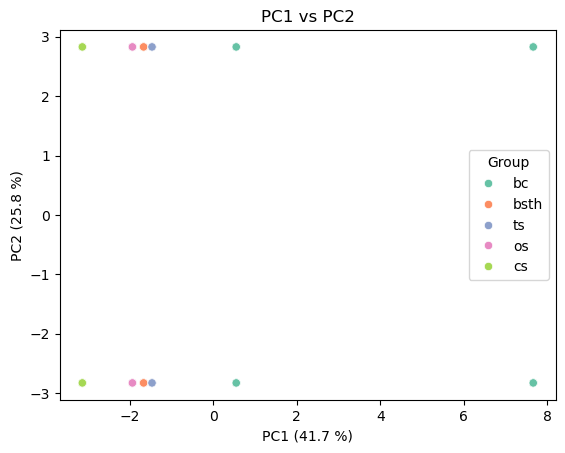

In [515]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

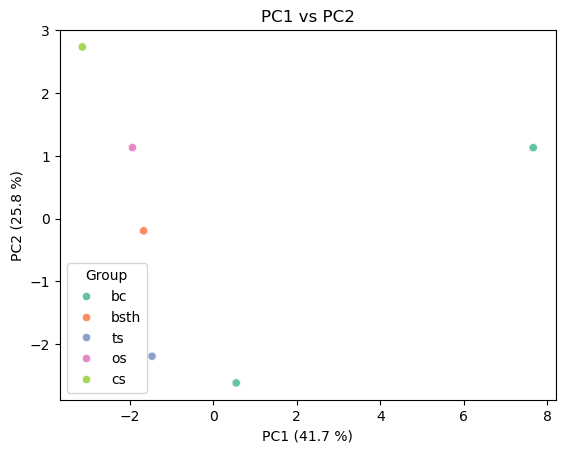

In [516]:
sns.scatterplot(data=pca_df, x="PC1", y="PC3", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

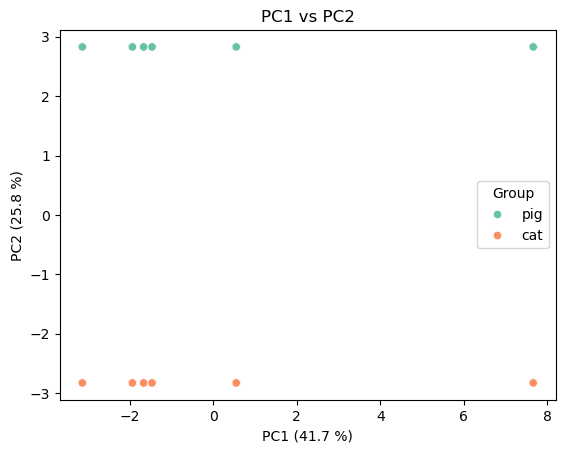

In [517]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

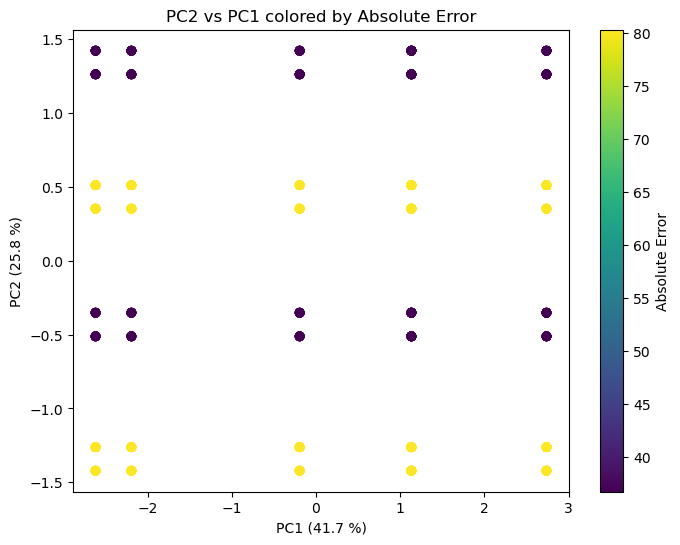

In [522]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['PC3'], pca_df['PC5'], c=pca_df['tan.app'], cmap='viridis')
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.colorbar(scatter, label='Absolute Error')
plt.title('PC2 vs PC1 colored by Absolute Error')
plt.show()

### Avec le temps et la météo

In [366]:
X_pca = data_scenarios_with_h.iloc[:, np.r_[-1072:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].values

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[38.01837714 23.52941176 10.66047183]


In [367]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

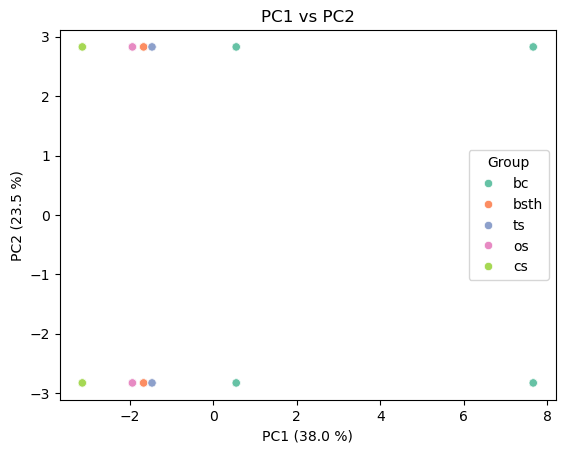

In [368]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

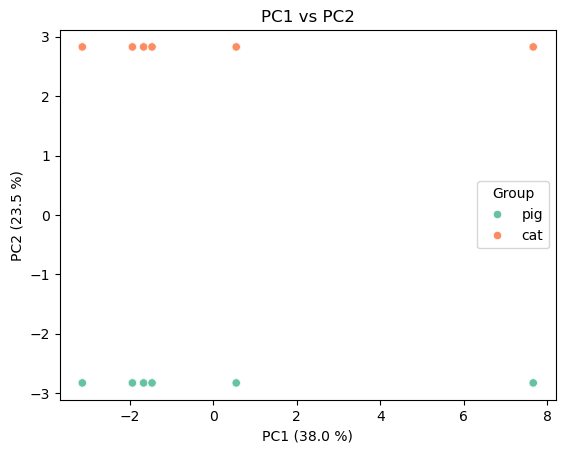

In [369]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## PCA on h1

In [370]:
X_pca = data_scenarios_with_h.iloc[:, -1024:].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[25.378191   9.996042   6.6567125]


In [371]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

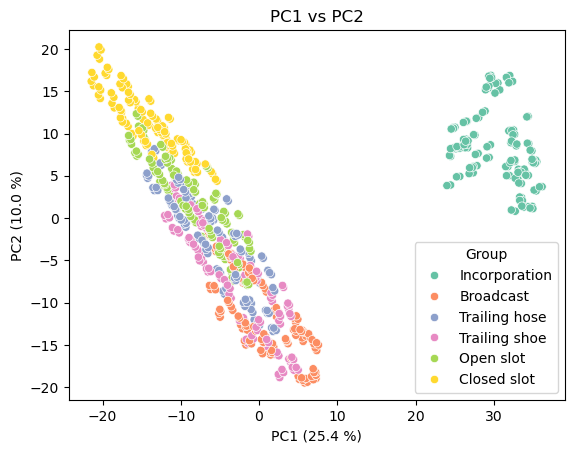

In [372]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

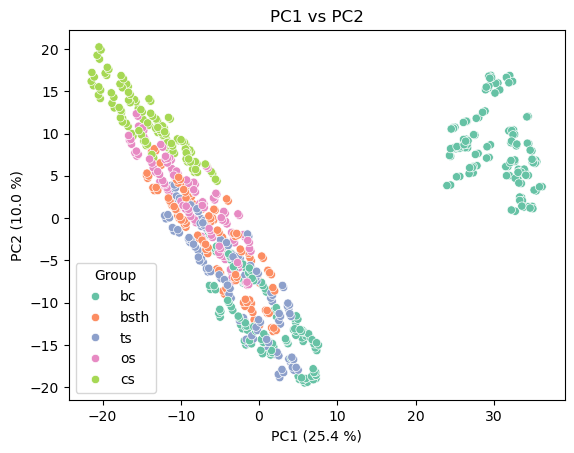

In [373]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

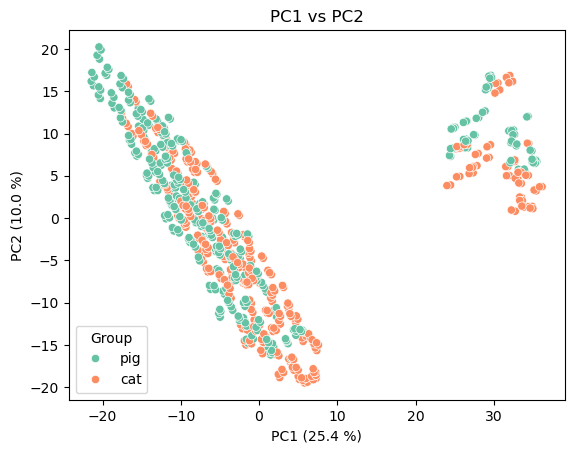

In [374]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## PCA on h2

In [375]:
X_pca = data_scenarios_with_h.iloc[:, -1030:-1024].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[80.5665    9.968758  4.809508]


In [376]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

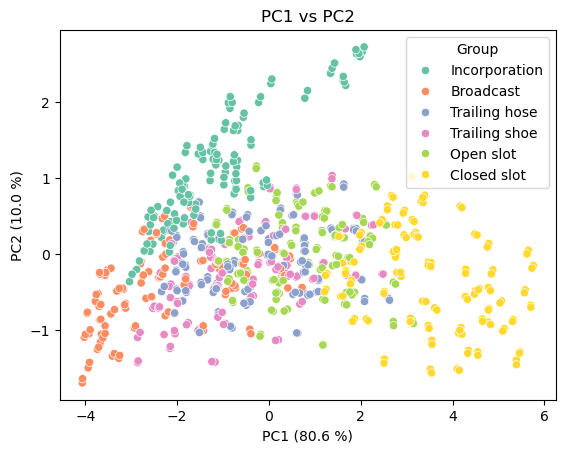

In [377]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

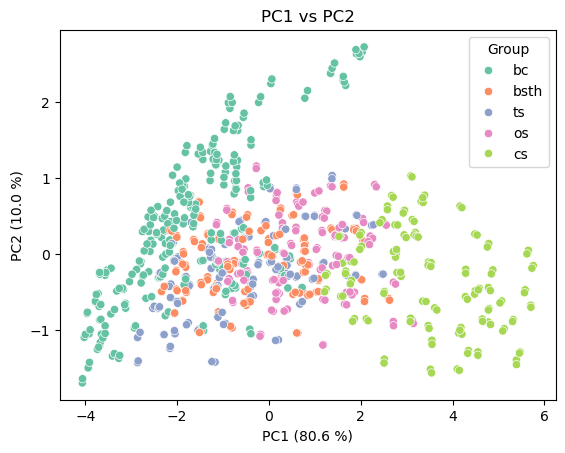

In [378]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

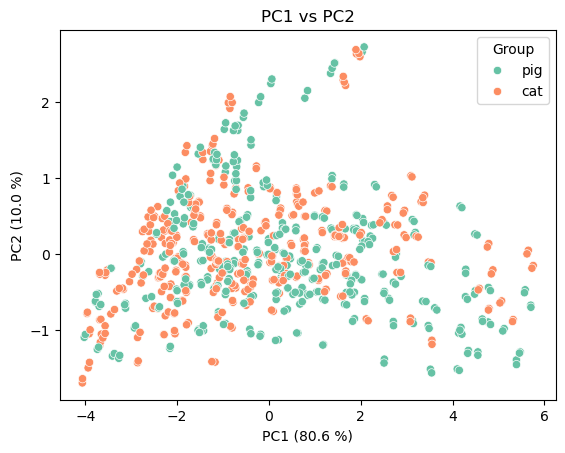

In [379]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## TSNE on h1

In [380]:
X_tsne = data_scenarios_with_h.iloc[:, -1024:].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [381]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [382]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

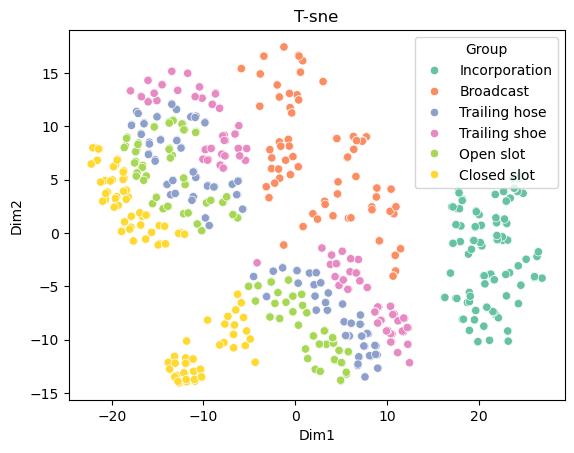

In [383]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

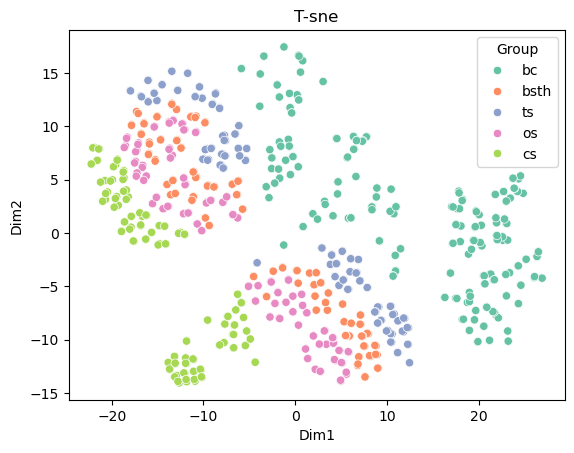

In [384]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

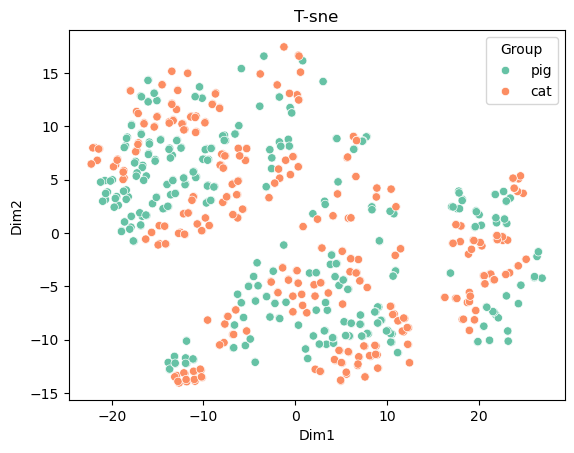

In [385]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

## TSNE on h2

In [386]:
X_tsne = data_scenarios_with_h.iloc[:, -1030:-1024].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [387]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [388]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

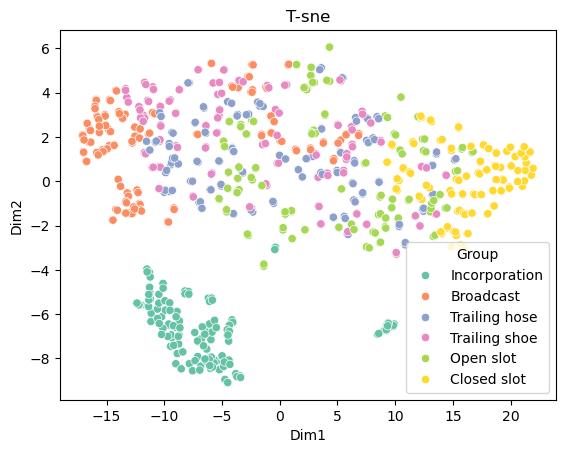

In [389]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

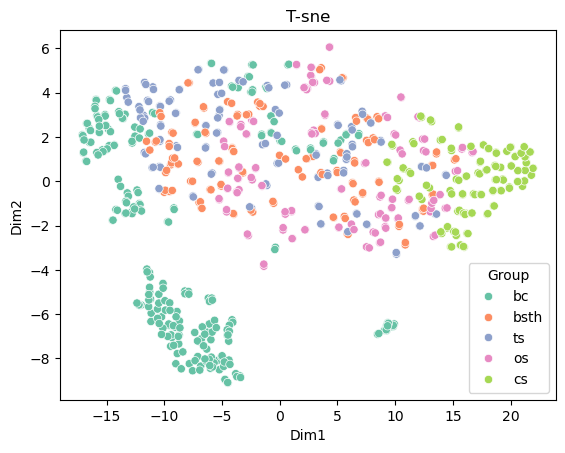

In [390]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

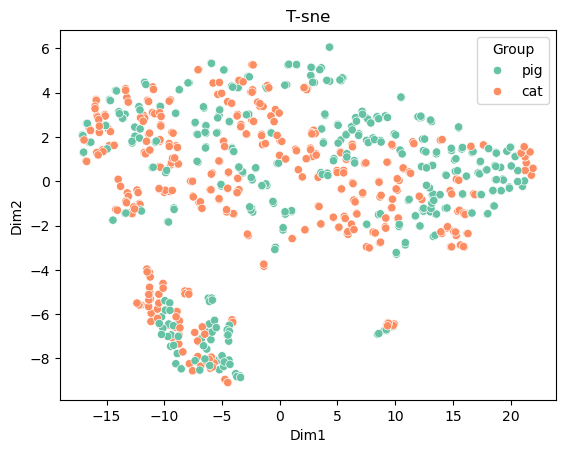

In [391]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

# At t = 12

In [392]:
data_scenarios_with_h = pd.concat(
    [data_scenarios.reset_index(drop=True),
     pd.DataFrame (all_x_embeds).reset_index(drop=True),
     pd.DataFrame (all_h2).reset_index(drop=True),
     pd.DataFrame (all_h1).reset_index(drop=True)],
    axis = 1)

In [393]:
data_scenarios_with_h = data_scenarios_with_h [data_scenarios_with_h['ct'] == 12]

In [394]:
data_scenarios_with_h.head (2)

scenario  pmid       strategy  group_temp  group_wind  group_rain  ct  dt  \
1          1  2001  Incorporation           1           1           1  12   6   
13         1  2002      Broadcast           1           1           1  12   6   

    air.temp   wind.2m  rain.rate  tan.app app.mthd  app.rate  man.dm  man.ph  \
1        9.4  1.966667        0.0     36.7       bc      18.7     3.8     7.5   
13       9.4  1.966667        0.0     36.7       bc      18.7     3.8     7.5   

   man.source   incorp  t.incorp  seq  ct_shift  prediction_ecum  \
1         pig  shallow         0    6         6         1.995975   
13        pig     none      1000    6         6         7.149005   

    prediction_delta_ecum         0         1         2         3         4  \
1                0.033392 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   
13               0.925731 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   

           5         6        7         8         9        10        11  \
1  -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.839846 -0.462206   
13 -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.395510 -0.540698   

          12        13        14        15        16        17        18  \
1  -1.322526  0.090657 -0.147480  0.778217  1.245540  0.851135 -0.951186   
13 -0.143261  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280   

          19        20       21        22       23        24        25  \
1   0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   
13  0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   

          26          0          1         2         3          4          5  \
1   0.514588  -7.591216 -48.069386 -4.695131 -3.956208 -81.756813 -23.461945   
13  0.514588 -14.285513 -55.920441 -8.351009  9.383415 -66.922012 -12.074900   

           0    1        2    3    4    5    6          7    8    9   10   11  \
1   0.000000  0.0  1.89978  0.0  0.0  0.0  0.0  20.596643  0.0  0.0  0.0  0.0   
13  9.505659  0.0  0.00000  0.0  0.0  0.0  0.0   0.000000  0.0  0.0  0.0  0.0   

          12        13         14   15   16   17   18        19   20  \
1   1.336561  8.111572  13.472546  0.0  0.0  0.0  0.0  9.005045  0.0   
13  0.000000  0.000000   0.000000  0.0  0.0  0.0  0.0  0.000000  0.0   

          21   22         23        24        25   26        27         28  \
1   0.000000  0.0  14.878452  6.550833  0.000000  0.0  1.933321   0.000000   
13  7.220146  0.0   0.000000  0.000000  3.504182  0.0  0.000000  17.936651   

     29   30        31   32        33        34   35   36   37   38   39   40  \
1   0.0  0.0  21.32954  0.0  0.024718  5.880864  0.0  0.0  0.0  0.0  0.0  0.0   
13  0.0  0.0   0.00000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   

     41   42   43         44   45   46        47        48   49   50   51  \
1   0.0  0.0  0.0  10.666677  0.0  0.0  0.000000  5.495803  0.0  0.0  0.0   
13  0.0  0.0  0.0   0.000000  0.0  0.0  3.274095  0.000000  0.0  0.0  0.0   

     52   53        54   55   56   57        58   59       60   61        62  \
1   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.00000  0.0  1.834308   
13  0.0  0.0  5.980004  0.0  0.0  0.0  1.082401  0.0  4.25307  0.0  3.395840   

          63        64         65   66   67   68        69   70   71  \
1   6.710564  1.300224   2.292767  0.0  0.0  0.0  1.908113  0.0  0.0   
13  1.637692  0.000000  20.189407  0.0  0.0  0.0  0.000000  0.0  0.0   

          72   73   74        75   76   77   78         79         80   81  \
1   7.272038  0.0  0.0  7.321065  0.0  0.0  0.0   0.000000  12.146337  0.0   
13  0.000000  0.0  0.0  3.206701  0.0  0.0  0.0  14.182551   5.037271  0.0   

     82   83        84   85        86   87        88        89   90  \
1   0.0  0.0  2.077818  0.0  5.029531  0.0  9.304382  4.337733  0.0   
13  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0   

           91   92   93        94   95   96   97   98         99  100  101 

## PCA on x_embeds

### Sans le temps et la météo

In [395]:
data_scenarios_with_h.iloc[:, np.r_[-1072:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].head()

air.temp   wind.2m  rain.rate  tan.app  app.rate  man.dm  man.ph  \
1        9.4  1.966667        0.0     36.7      18.7     3.8     7.5   
13       9.4  1.966667        0.0     36.7      18.7     3.8     7.5   
25       9.4  1.966667        0.0     36.7      18.7     3.8     7.5   
37       9.4  1.966667        0.0     36.7      18.7     3.8     7.5   
49       9.4  1.966667        0.0     36.7      18.7     3.8     7.5   

    t.incorp         0         1         2         3         4         5  \
1          0 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096 -1.012481   
13      1000 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096 -1.012481   
25      1000 -0.694728 -0.124331 -0.100394  2.166680  0.364520  1.307028   
37      1000 -0.661530  0.056595  2.186193  0.019265  0.150248 -0.403367   
49      1000  1.346063  0.821633 -0.445946  1.066994  1.431368 -0.093620   

           6         7         8         9        10        11        12  \
1  -0.766921 -1.965260 -1.050162  0.478234 -0.839846 -0.462206 -1.322526   
13 -0.766921 -1.965260 -1.050162  0.478234 -0.395510 -0.540698 -0.143261   
25 -0.776015 -1.023266  0.923928 -0.065374 -0.395510 -0.540698 -0.143261   
37  0.843215  0.721650  1.315798  2.386029 -0.395510 -0.540698 -0.143261   
49 -2.511866 -1.302905  0.212443 -1.044058 -0.395510 -0.540698 -0.143261   

          13        14        15        16        17        18        19  \
1   0.090657 -0.147480  0.778217  1.245540  0.851135 -0.951186  0.805263   
13  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   
25  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   
37  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   
49  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263   

          20       21        22       23        24        25        26  
1   0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
13  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
25  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
37  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
49  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588

In [396]:
data_scenarios_with_h.iloc[:, np.r_[-1069:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].head()

tan.app  app.rate  man.dm  man.ph  t.incorp         0         1         2  \
1      36.7      18.7     3.8     7.5         0 -1.854915 -1.119467 -1.016169   
13     36.7      18.7     3.8     7.5      1000 -1.854915 -1.119467 -1.016169   
25     36.7      18.7     3.8     7.5      1000 -0.694728 -0.124331 -0.100394   
37     36.7      18.7     3.8     7.5      1000 -0.661530  0.056595  2.186193   
49     36.7      18.7     3.8     7.5      1000  1.346063  0.821633 -0.445946   

           3         4         5         6         7         8         9  \
1  -1.991602 -0.418096 -1.012481 -0.766921 -1.965260 -1.050162  0.478234   
13 -1.991602 -0.418096 -1.012481 -0.766921 -1.965260 -1.050162  0.478234   
25  2.166680  0.364520  1.307028 -0.776015 -1.023266  0.923928 -0.065374   
37  0.019265  0.150248 -0.403367  0.843215  0.721650  1.315798  2.386029   
49  1.066994  1.431368 -0.093620 -2.511866 -1.302905  0.212443 -1.044058   

          10        11        12        13        14        15        16  \
1  -0.839846 -0.462206 -1.322526  0.090657 -0.147480  0.778217  1.245540   
13 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
25 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
37 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
49 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   

          17        18        19        20       21        22       23  \
1   0.851135 -0.951186  0.805263  0.761223  1.04206  0.504151 -0.92198   
13  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
25  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
37  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
49  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   

          24        25        26  
1   1.623209  0.465516  0.514588  
13  1.623209  0.465516  0.514588  
25  1.623209  0.465516  0.514588  
37  1.623209  0.465516  0.514588  
49  1.623209  0.465516  0.514588

In [397]:
X_pca = data_scenarios_with_h.iloc[:, np.r_[-1069:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].values

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[41.69757493 25.80645161 11.6921304 ]


In [398]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

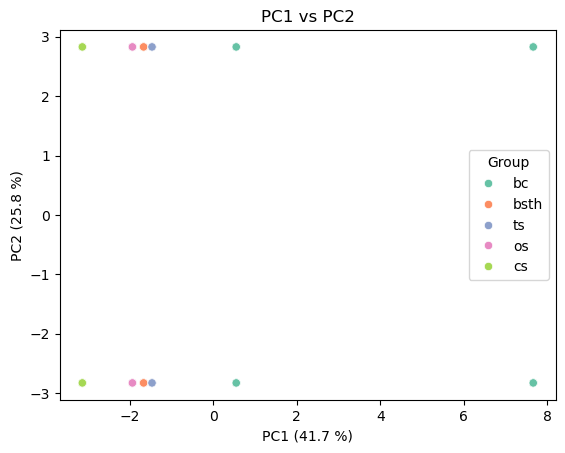

In [399]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

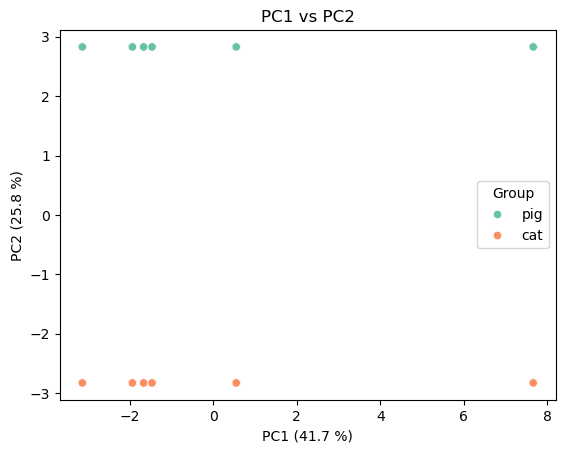

In [400]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

### Avec le temps et la météo

In [401]:
X_pca = data_scenarios_with_h.iloc[:, np.r_[-1072:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].values

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[38.01837714 23.52941176 10.66047183]


In [402]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

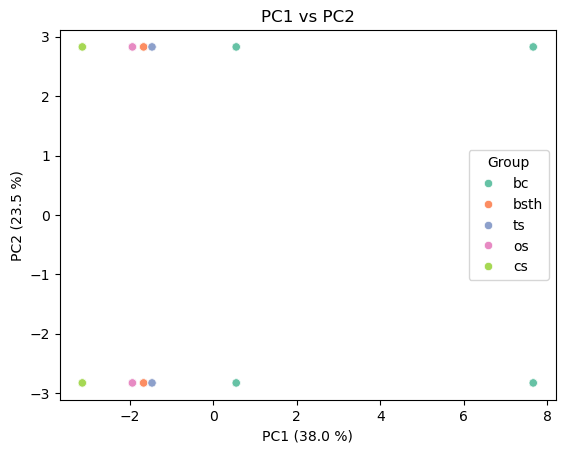

In [403]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

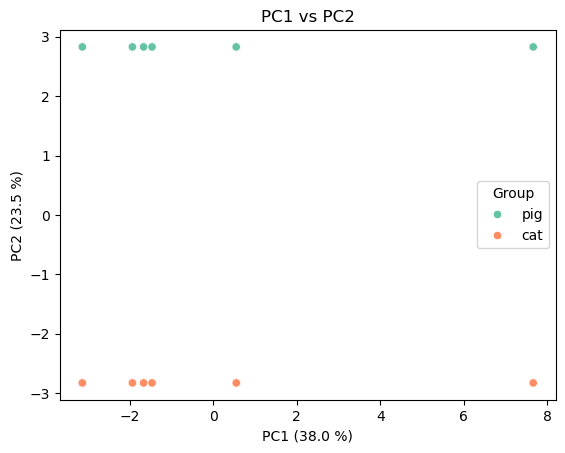

In [404]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## PCA on h1

In [405]:
X_pca = data_scenarios_with_h.iloc[:, -1024:].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[15.208758   9.315135   6.6036167]


In [406]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

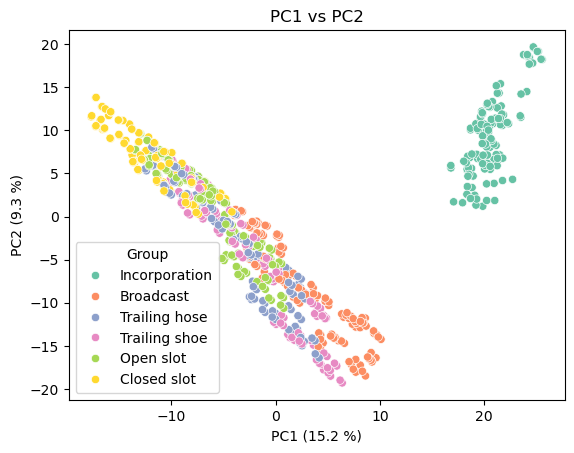

In [407]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

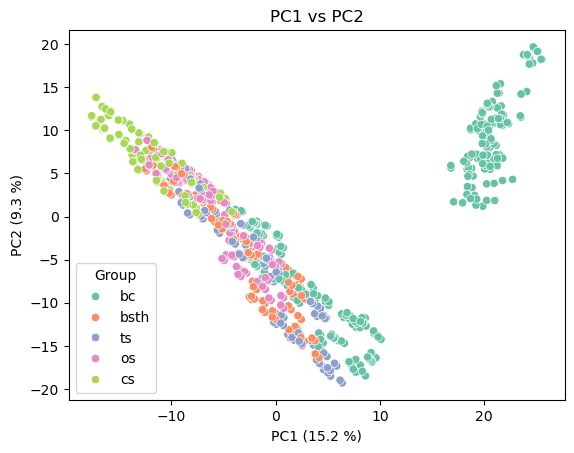

In [408]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

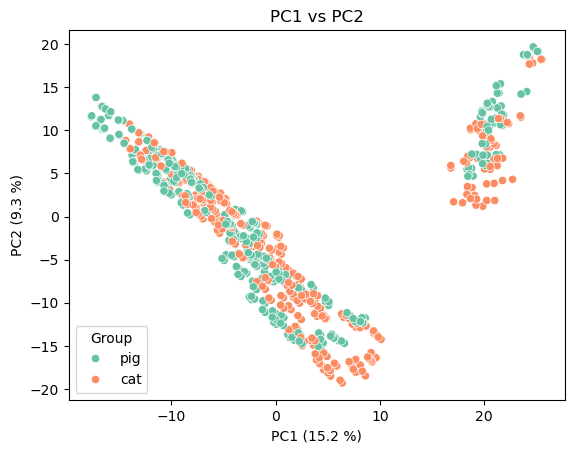

In [409]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## PCA on h2

In [410]:
X_pca = data_scenarios_with_h.iloc[:, -1030:-1024].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[76.77878  11.64071   6.559526]


In [411]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

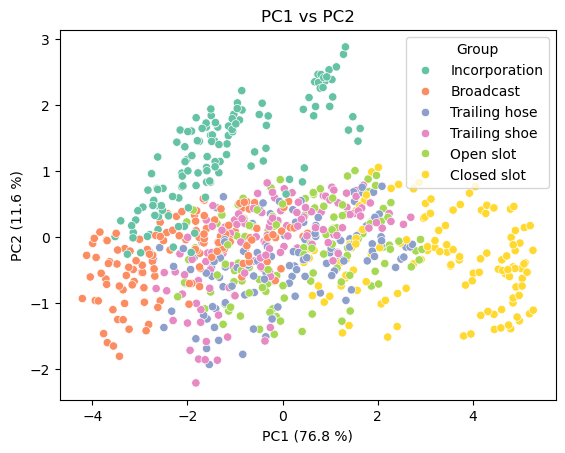

In [412]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

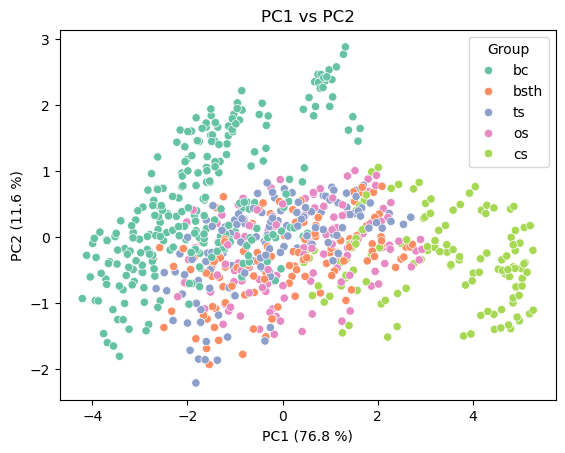

In [413]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

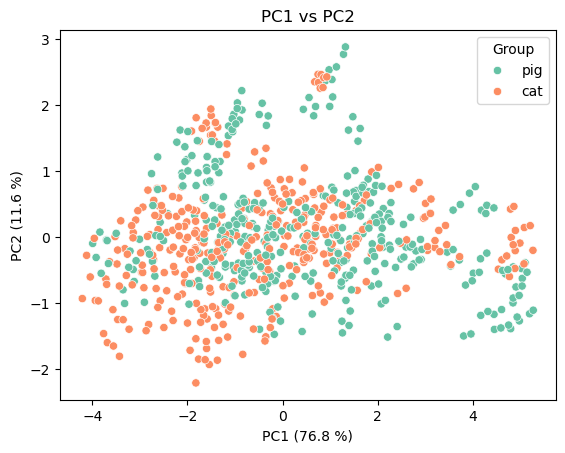

In [414]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## TSNE on h1

In [415]:
X_tsne = data_scenarios_with_h.iloc[:, -1024:].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [416]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [417]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

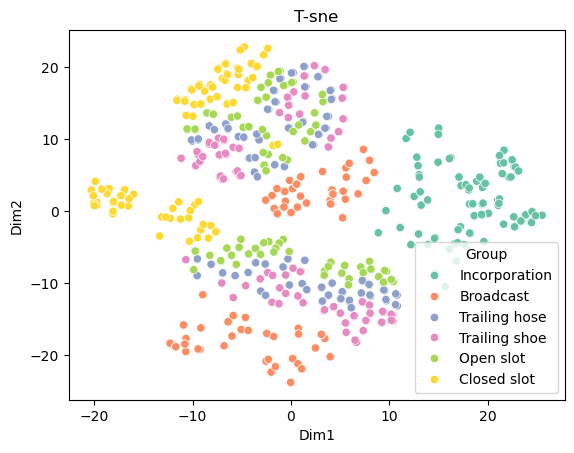

In [418]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

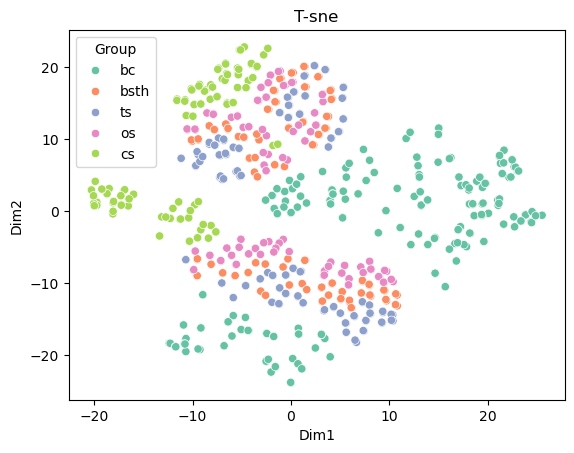

In [419]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

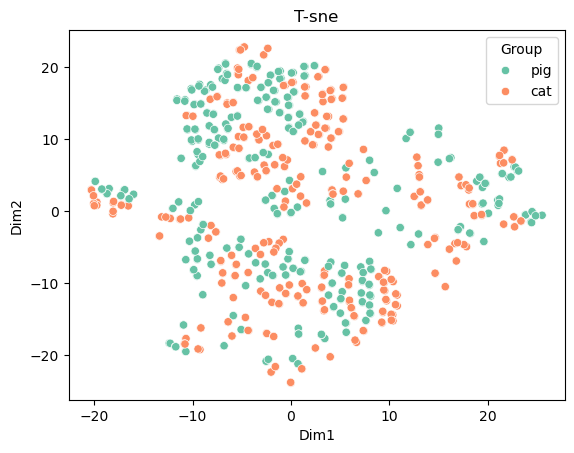

In [420]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

## TSNE on h2

In [421]:
X_tsne = data_scenarios_with_h.iloc[:, -1030:-1024].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [422]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [423]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

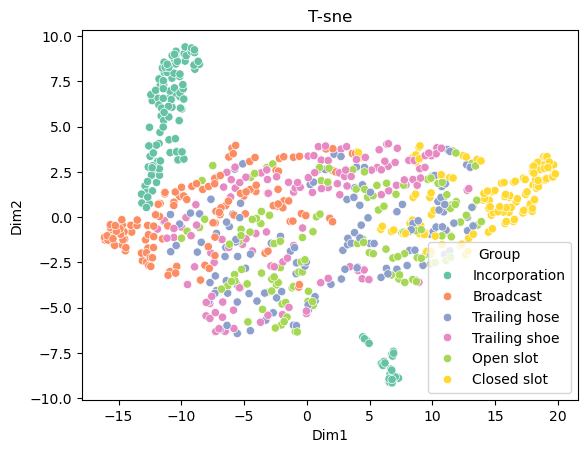

In [424]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

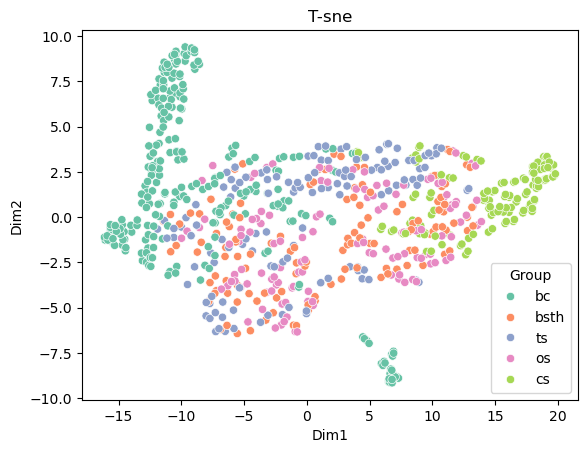

In [425]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

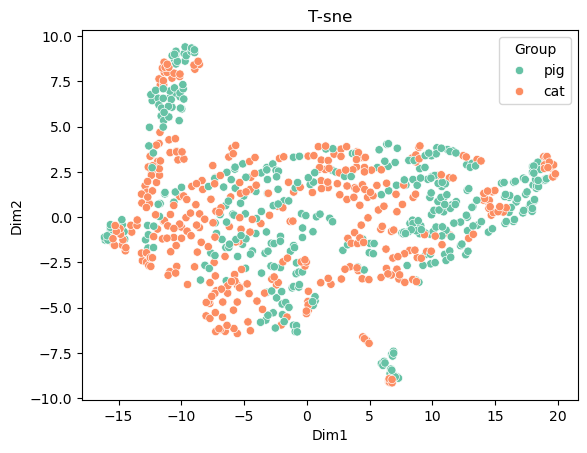

In [426]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

# At t = 72

In [427]:
data_scenarios_with_h = pd.concat(
    [data_scenarios.reset_index(drop=True),
     pd.DataFrame (all_x_embeds).reset_index(drop=True),
     pd.DataFrame (all_h2).reset_index(drop=True),
     pd.DataFrame (all_h1).reset_index(drop=True)],
    axis = 1)

In [428]:
data_scenarios_with_h = data_scenarios_with_h [data_scenarios_with_h['ct'] == 72]

In [429]:
data_scenarios_with_h.head (2)

scenario  pmid       strategy  group_temp  group_wind  group_rain  ct  dt  \
11         1  2001  Incorporation           1           1           1  72   6   
23         1  2002      Broadcast           1           1           1  72   6   

    air.temp  wind.2m  rain.rate  tan.app app.mthd  app.rate  man.dm  man.ph  \
11       9.2      2.2        0.0     36.7       bc      18.7     3.8     7.5   
23       9.2      2.2        0.0     36.7       bc      18.7     3.8     7.5   

   man.source   incorp  t.incorp  seq  ct_shift  prediction_ecum  \
11        pig  shallow         0    6        66         4.920022   
23        pig     none      1000    6        66         8.979637   

    prediction_delta_ecum         0         1         2         3         4  \
11               0.046726 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   
23               0.033392 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   

           5         6        7         8         9        10        11  \
11 -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.839846 -0.462206   
23 -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.395510 -0.540698   

          12        13        14        15        16        17        18  \
11 -1.322526  0.090657 -0.147480  0.778217  1.245540  0.851135 -0.951186   
23 -0.143261  0.000184  1.370667  0.005575  0.634749  0.515844 -0.816280   

          19        20       21        22       23        24        25  \
11  0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   
23  0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   

          26          0          1         2         3          4          5  \
11  0.514588  -5.606366 -46.150581 -5.211696  0.140216 -49.181671 -14.056669   
23  0.514588 -13.273210 -57.700577 -9.568283 -4.568285 -81.251930 -34.527718   

      0         1         2    3    4    5          6    7    8    9   10  \
11  0.0  3.041335  0.000000  0.0  0.0  0.0   0.000000  0.0  0.0  0.0  0.0   
23  0.0  0.000000  3.306919  0.0  0.0  0.0  18.288879  0.0  0.0  0.0  0.0   

     11         12   13   14         15   16   17        18   19   20  \
11  0.0  13.088632  0.0  0.0  13.195179  0.0  0.0  0.000000  0.0  0.0   
23  0.0   0.000000  0.0  0.0   0.000000  0.0  0.0  0.443962  0.0  0.0   

          21   22   23   24   25   26   27       28   29       30   31   32  \
11  3.022564  0.0  0.0  0.0  0.0  0.0  0.0  0.00000  0.0  1.87346  0.0  0.0   
23  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  2.02756  0.0  0.00000  0.0  0.0   

     33   34   35   36   37        38        39   40   41   42   43   44   45  \
11  0.0  0.0  0.0  0.0  0.0  4.122216  0.338132  0.0  0.0  0.0  0.0  0.0  0.0   
23  0.0  0.0  0.0  0.0  0.0  0.000000  2.298086  0.0  0.0  0.0  0.0  0.0  0.0   

     46        47   48   49   50   51   52   53   54   55   56   57  \
11  0.0  2.285182  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
23  0.0  7.818496  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

           58        59        60        61   62   63         64         65  \
11   0.000000  0.000000  0.000000  1.205878  0.0  0.0   2.991015   7.005985   
23  13.421073  6.625048  0.075862  0.000000  0.0  0.0  16.620342  25.129948   

     66   67   68   69   70   71        72        73   74        75   76   77  \
11  0.0  0.0  0.0  0.0  0.0  0.0  9.588003  0.181676  0.0  0.000000  0.0  0.0   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  6.744845  0.0  0.0   

     78         79   80   81   82   83   84   85   86   87        88  \
11  0.0   0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.669108   
23  0.0  18.618347  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   

          89   90   91   92   93   94   95   96   97   98        99  100  \
11  3.458116  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  7.872606  0.0   
23  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.705602  0.0   

          101  102       103  104  105  106  107  108  109  110       111  \
11  

## PCA on x_embeds

### Sans le temps et la météo

In [430]:
data_scenarios_with_h.iloc[:, np.r_[-1072:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].head()

air.temp  wind.2m  rain.rate  tan.app  app.rate  man.dm  man.ph  t.incorp  \
11       9.2      2.2        0.0     36.7      18.7     3.8     7.5         0   
23       9.2      2.2        0.0     36.7      18.7     3.8     7.5      1000   
35       9.2      2.2        0.0     36.7      18.7     3.8     7.5      1000   
47       9.2      2.2        0.0     36.7      18.7     3.8     7.5      1000   
59       9.2      2.2        0.0     36.7      18.7     3.8     7.5      1000   

           0         1         2         3         4         5         6  \
11 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096 -1.012481 -0.766921   
23 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096 -1.012481 -0.766921   
35 -0.694728 -0.124331 -0.100394  2.166680  0.364520  1.307028 -0.776015   
47 -0.661530  0.056595  2.186193  0.019265  0.150248 -0.403367  0.843215   
59  1.346063  0.821633 -0.445946  1.066994  1.431368 -0.093620 -2.511866   

           7         8         9        10        11        12        13  \
11 -1.965260 -1.050162  0.478234 -0.839846 -0.462206 -1.322526  0.090657   
23 -1.965260 -1.050162  0.478234 -0.395510 -0.540698 -0.143261  0.000184   
35 -1.023266  0.923928 -0.065374 -0.395510 -0.540698 -0.143261  0.000184   
47  0.721650  1.315798  2.386029 -0.395510 -0.540698 -0.143261  0.000184   
59 -1.302905  0.212443 -1.044058 -0.395510 -0.540698 -0.143261  0.000184   

          14        15        16        17        18        19        20  \
11 -0.147480  0.778217  1.245540  0.851135 -0.951186  0.805263  0.761223   
23  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263  0.761223   
35  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263  0.761223   
47  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263  0.761223   
59  1.370667  0.005575  0.634749  0.515844 -0.816280  0.805263  0.761223   

         21        22       23        24        25        26  
11  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
23  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
35  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
47  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588  
59  1.04206  0.504151 -0.92198  1.623209  0.465516  0.514588

In [431]:
data_scenarios_with_h.iloc[:, np.r_[-1069:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].head()

tan.app  app.rate  man.dm  man.ph  t.incorp         0         1         2  \
11     36.7      18.7     3.8     7.5         0 -1.854915 -1.119467 -1.016169   
23     36.7      18.7     3.8     7.5      1000 -1.854915 -1.119467 -1.016169   
35     36.7      18.7     3.8     7.5      1000 -0.694728 -0.124331 -0.100394   
47     36.7      18.7     3.8     7.5      1000 -0.661530  0.056595  2.186193   
59     36.7      18.7     3.8     7.5      1000  1.346063  0.821633 -0.445946   

           3         4         5         6         7         8         9  \
11 -1.991602 -0.418096 -1.012481 -0.766921 -1.965260 -1.050162  0.478234   
23 -1.991602 -0.418096 -1.012481 -0.766921 -1.965260 -1.050162  0.478234   
35  2.166680  0.364520  1.307028 -0.776015 -1.023266  0.923928 -0.065374   
47  0.019265  0.150248 -0.403367  0.843215  0.721650  1.315798  2.386029   
59  1.066994  1.431368 -0.093620 -2.511866 -1.302905  0.212443 -1.044058   

          10        11        12        13        14        15        16  \
11 -0.839846 -0.462206 -1.322526  0.090657 -0.147480  0.778217  1.245540   
23 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
35 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
47 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   
59 -0.395510 -0.540698 -0.143261  0.000184  1.370667  0.005575  0.634749   

          17        18        19        20       21        22       23  \
11  0.851135 -0.951186  0.805263  0.761223  1.04206  0.504151 -0.92198   
23  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
35  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
47  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   
59  0.515844 -0.816280  0.805263  0.761223  1.04206  0.504151 -0.92198   

          24        25        26  
11  1.623209  0.465516  0.514588  
23  1.623209  0.465516  0.514588  
35  1.623209  0.465516  0.514588  
47  1.623209  0.465516  0.514588  
59  1.623209  0.465516  0.514588

In [432]:
X_pca = data_scenarios_with_h.iloc[:, np.r_[-1069:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].values

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[41.69757493 25.80645161 11.6921304 ]


In [433]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

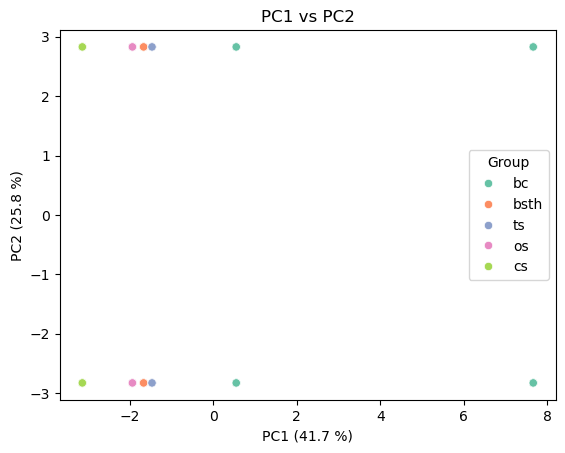

In [434]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

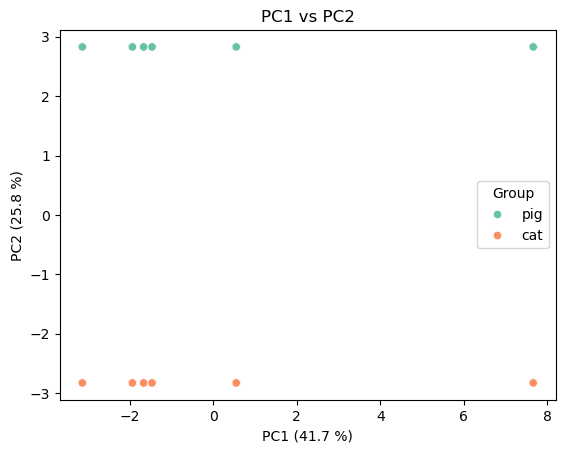

In [435]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

### Avec le temps et la météo

In [436]:
X_pca = data_scenarios_with_h.iloc[:, np.r_[-1072:-1068, -1067:-1064, -1062:-1061, -1057: -1030]].values

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[38.01837714 23.52941176 10.66047183]


In [437]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

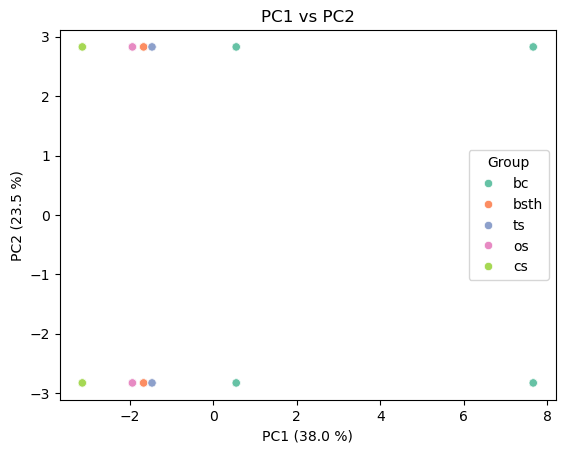

In [438]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

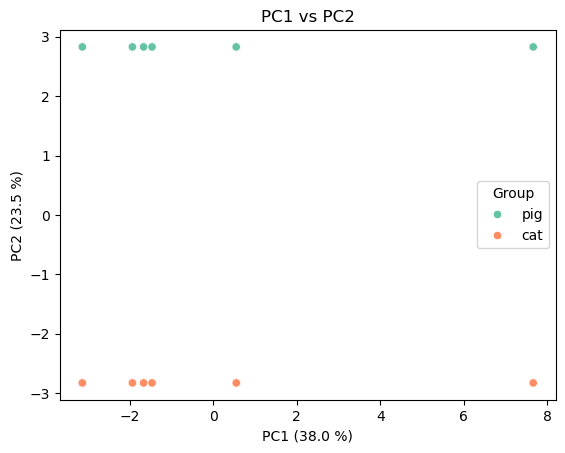

In [439]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## PCA on h1

In [440]:
X_pca = data_scenarios_with_h.iloc[:, -1024:].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[28.429476   9.793978   7.3854976]


In [441]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

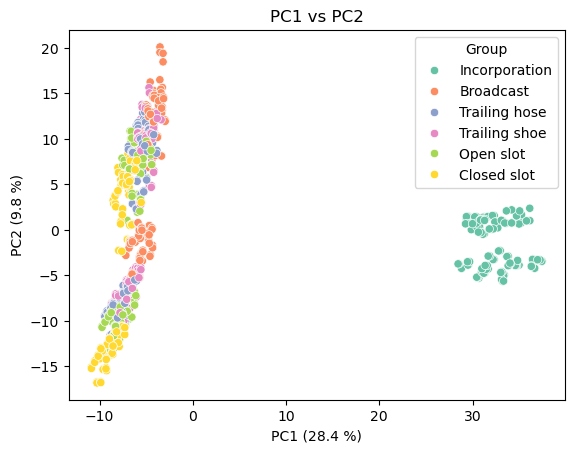

In [442]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

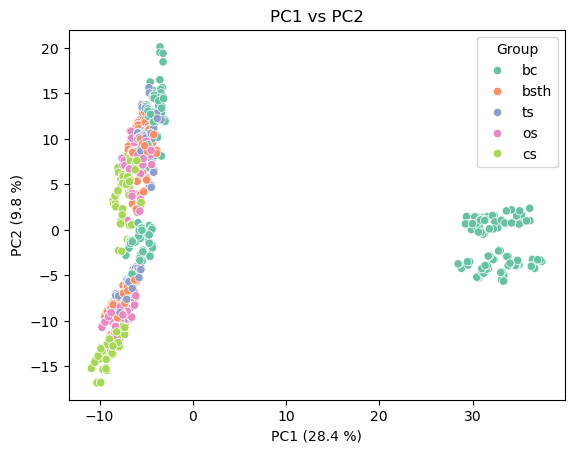

In [443]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

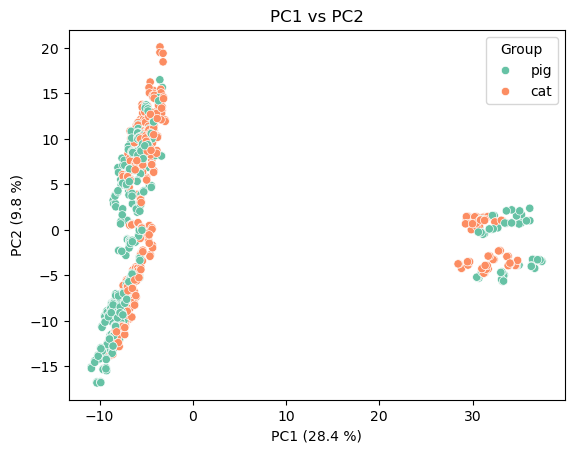

In [444]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## PCA on h2

In [445]:
X_pca = data_scenarios_with_h.iloc[:, -1030:-1024].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[65.9976   14.262409 11.875677]


In [446]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

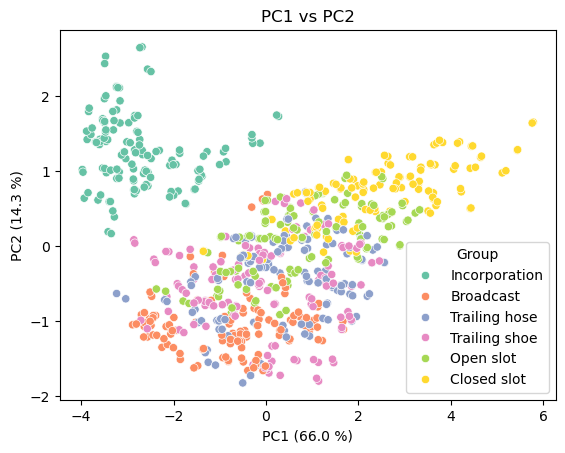

In [447]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

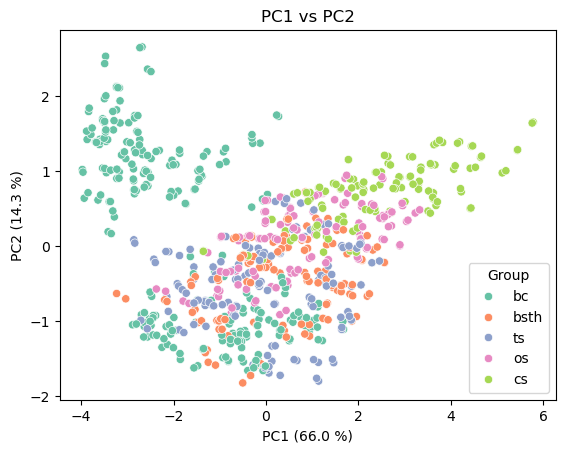

In [448]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

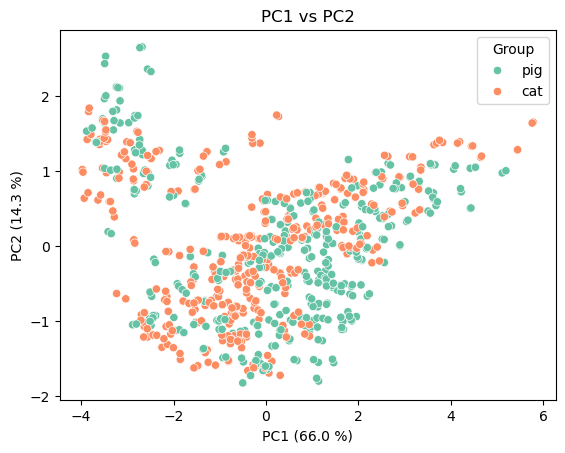

In [449]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## TSNE on h1

In [450]:
X_tsne = data_scenarios_with_h.iloc[:, -1024:].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [451]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [452]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

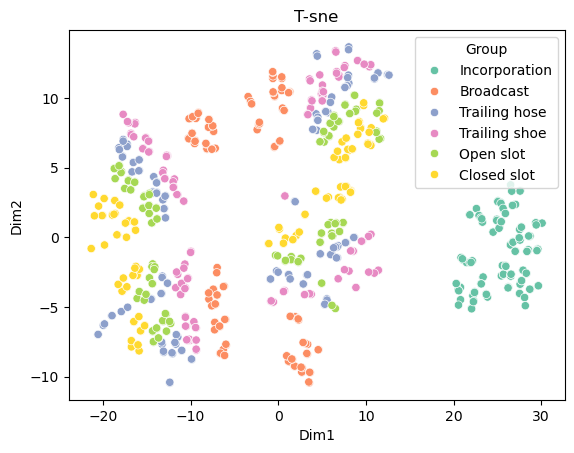

In [453]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

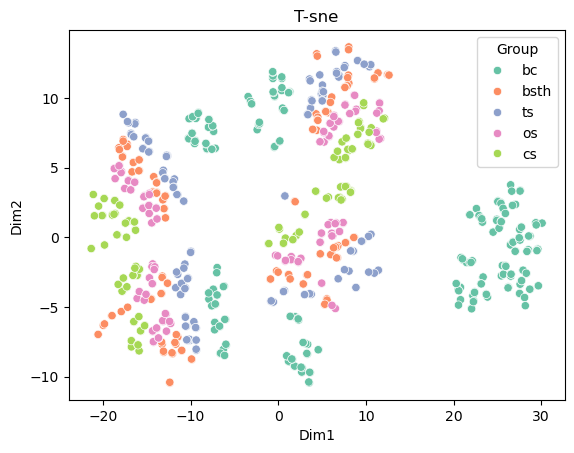

In [454]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

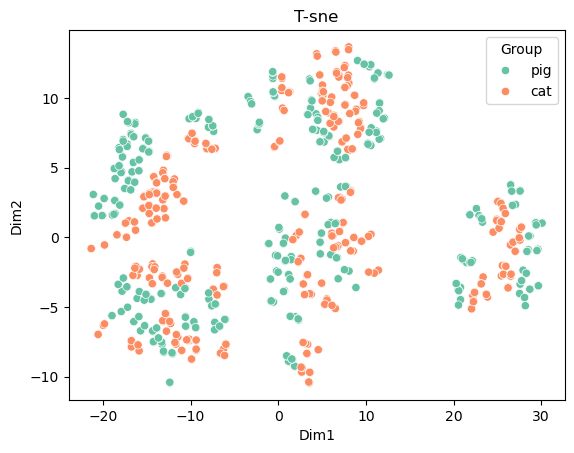

In [455]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

## TSNE on h2

In [456]:
X_tsne = data_scenarios_with_h.iloc[:, -1030:-1024].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [457]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [458]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

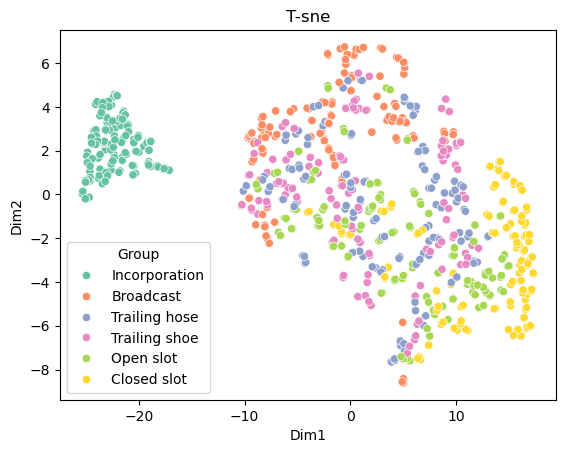

In [459]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

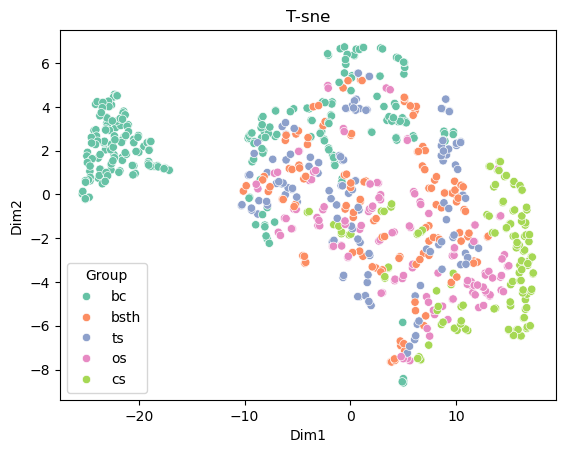

In [460]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

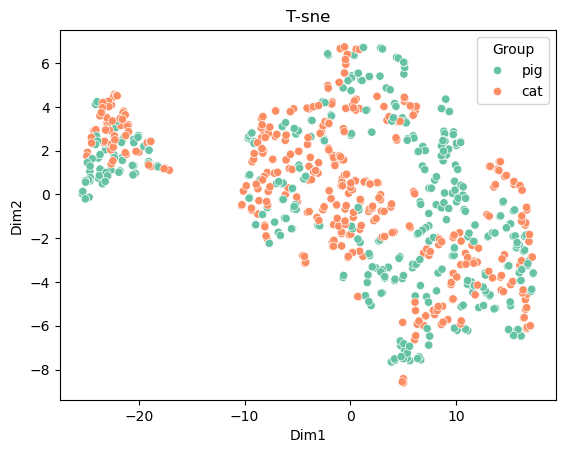

In [461]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

# At all times

In [462]:
data_scenarios_with_h = pd.concat(
    [data_scenarios.reset_index(drop=True),
     pd.DataFrame (all_x_embeds).reset_index(drop=True),
     pd.DataFrame (all_h2).reset_index(drop=True),
     pd.DataFrame (all_h1).reset_index(drop=True)],
    axis = 1)

In [463]:
data_scenarios_with_h.head (2)

scenario  pmid       strategy  group_temp  group_wind  group_rain  ct  dt  \
0         1  2001  Incorporation           1           1           1   6   6   
1         1  2001  Incorporation           1           1           1  12   6   

    air.temp   wind.2m  rain.rate  tan.app app.mthd  app.rate  man.dm  man.ph  \
0  11.066667  2.300000        0.0     36.7       bc      18.7     3.8     7.5   
1   9.400000  1.966667        0.0     36.7       bc      18.7     3.8     7.5   

  man.source   incorp  t.incorp  seq  ct_shift  prediction_ecum  \
0        pig  shallow         0    6         0         1.962584   
1        pig  shallow         0    6         6         1.995975   

   prediction_delta_ecum         0         1         2         3         4  \
0               1.962584 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   
1               0.033392 -1.854915 -1.119467 -1.016169 -1.991602 -0.418096   

          5         6        7         8         9        10        11  \
0 -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.839846 -0.462206   
1 -1.012481 -0.766921 -1.96526 -1.050162  0.478234 -0.839846 -0.462206   

         12        13       14        15       16        17        18  \
0 -1.322526  0.090657 -0.14748  0.778217  1.24554  0.851135 -0.951186   
1 -1.322526  0.090657 -0.14748  0.778217  1.24554  0.851135 -0.951186   

         19        20       21        22       23        24        25  \
0  0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   
1  0.805263  0.761223  1.04206  0.504151 -0.92198  1.623209  0.465516   

         26         0          1         2          3          4          5  \
0  0.514588 -5.626672  -3.087967 -4.091456  20.286472 -19.480667  -0.775877   
1  0.514588 -7.591216 -48.069386 -4.695131  -3.956208 -81.756813 -23.461945   

          0    1        2         3         4         5    6          7  \
0  3.095272  0.0  0.00000  4.818062  1.456873  2.571879  0.0   3.370545   
1  0.000000  0.0  1.89978  0.000000  0.000000  0.000000  0.0  20.596643   

          8    9        10        11        12        13         14   15   16  \
0  2.040388  0.0  2.092163  1.712083  2.310251  0.000000   5.453723  0.0  0.0   
1  0.000000  0.0  0.000000  0.000000  1.336561  8.111572  13.472546  0.0  0.0   

         17   18        19   20   21        22         23        24        25  \
0  1.297186  0.0  5.576601  0.0  0.0  0.716901   5.147791  3.037886  1.730061   
1  0.000000  0.0  9.005045  0.0  0.0  0.000000  14.878452  6.550833  0.000000   

    26        27   28        29   30         31   32        33        34   35  \
0  0.0  0.682911  0.0  2.551709  0.0   1.802823  0.0  0.000000  0.510401  0.0   
1  0.0  1.933321  0.0  0.000000  0.0  21.329540  0.0  0.024718  5.880864  0.0   

         36   37   38        39        40        41   42        43         44  \
0  2.919871  0.0  0.0  3.711581  2.933553  0.850299  0.0  4.780388   4.569801   
1  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.000000  10.666677   

         45   46   47        48   49   50   51        52   53   54        55  \
0  1.099273  0.0  0.0  3.704037  0.0  0.0  0.0  5.890944  0.0  0.0  3.472017   
1  0.000000  0.0  0.0  5.495803  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000   

        56        57        58   59   60   61        62        63        64  \
0  3.18103  1.345339  6.266679  0.0  0.0  0.0  0.000000  0.000000  1.074390   
1  0.00000  0.000000  0.000000  0.0  0.0  0.0  1.834308  6.710564  1.300224   

         65   66   67        68        69   70        71        72        73  \
0  0.000000  0.0  0.0  5.973127  0.000000  0.0  2.080787  1.562412  2.898884   
1  2.292767  0.0  0.0  0.000000  1.908113  0.0  0.000000  7.272038  0.000000   

         74        75        76        77   78   79         80   81   82  \
0  3.887407  1.771846  1.794371  0.978539  0.0  0.0   3.086900  0.0  0.0   
1  0.000000  7.321065  0.000000  0.000000  0.0  0.0  12.146337  0.0  0.0   

         83        84        

## PCA on h1

In [464]:
X_pca = data_scenarios_with_h.iloc[:, -1024:].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[8.112219  6.3341446 5.515174 ]


In [465]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

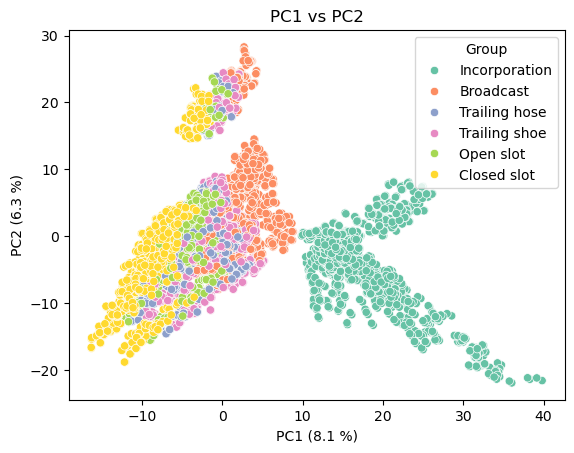

In [466]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

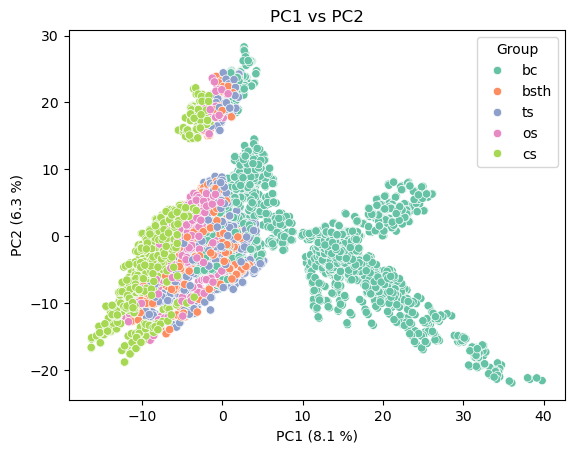

In [467]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

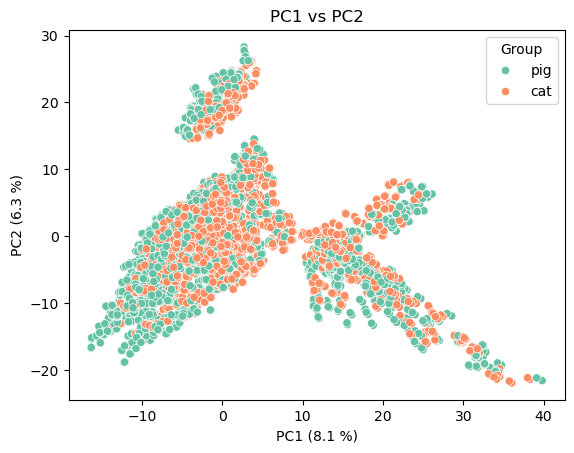

In [468]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## PCA on h2

In [469]:
X_pca = data_scenarios_with_h.iloc[:, -1030:-1024].values 

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Calcul de la variance expliquée pour chaque composante
explained_var = pca.explained_variance_ratio_ * 100  # En pourcentage

print (explained_var)

[69.16949   17.50875    6.8178415]


In [470]:
pca_df = pd.concat (
    [data_scenarios_with_h[['app.mthd', 'strategy', 'man.source']].reset_index(drop=True),
    pd.DataFrame(X_pca_transformed, columns=['PC1', 'PC2', 'PC3']).reset_index(drop=True)],
    axis = 1
)

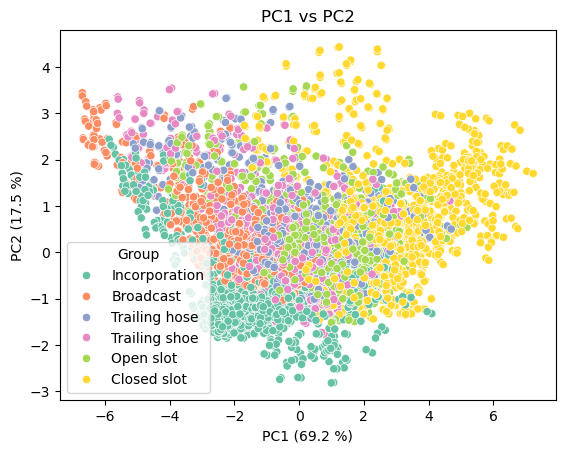

In [471]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="strategy", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

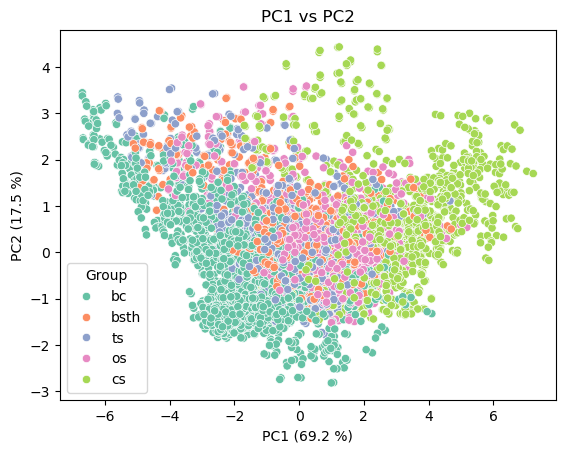

In [472]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="app.mthd", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

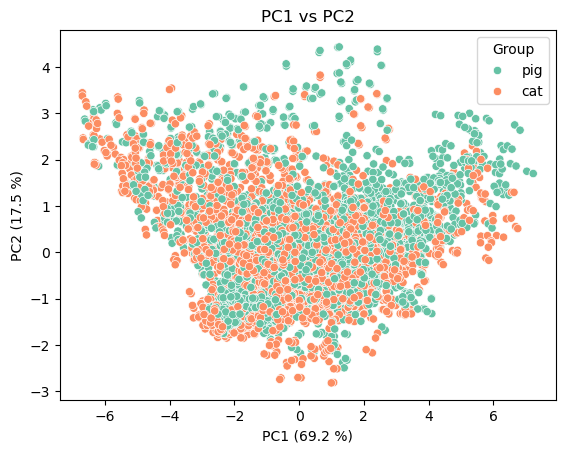

In [473]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="man.source", palette="Set2")

plt.title("PC1 vs PC2")
plt.xlabel(f'PC1 ({explained_var[0]:.1f} %)')
plt.ylabel(f'PC2 ({explained_var[1]:.1f} %)')
plt.legend(title="Group")
plt.show()

## TSNE on h1

In [474]:
X_tsne = data_scenarios_with_h.iloc[:, -1024:].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [475]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [476]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

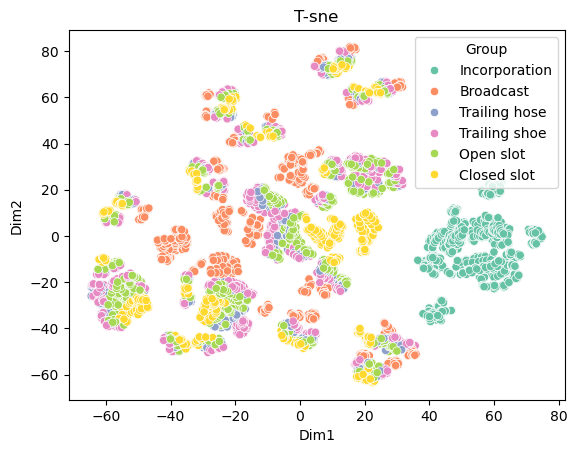

In [477]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

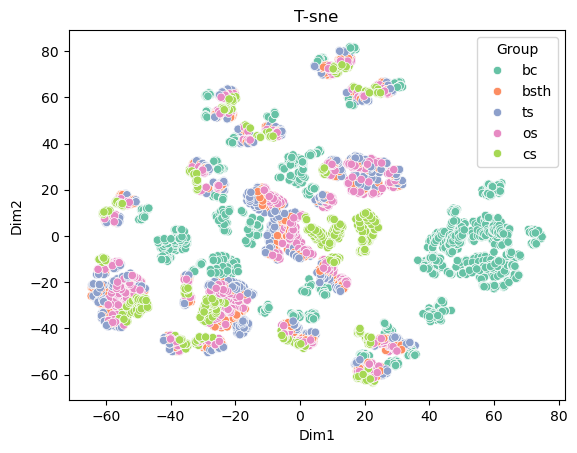

In [478]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

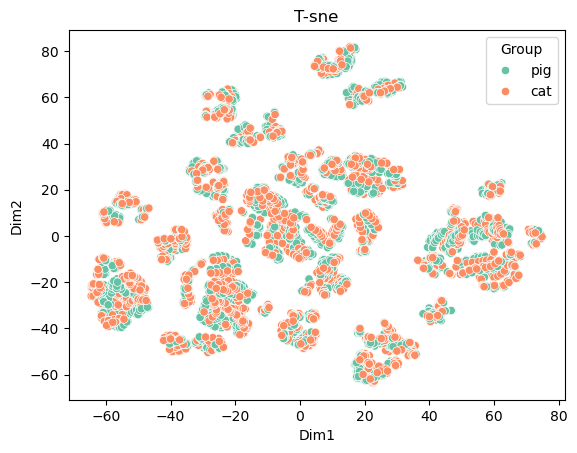

In [479]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

## TSNE on h2

In [480]:
X_tsne = data_scenarios_with_h.iloc[:, -1030:-1024].values

# Normalisation des données (important pour t-SNE)
scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

In [481]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
X_tsne_transformed = tsne.fit_transform(X_tsne_scaled)

In [482]:
tsne_df = pd.concat(
    [data_scenarios_with_h[['strategy', 'app.mthd', 'man.source']].reset_index(drop=True),
     pd.DataFrame(X_tsne_transformed, columns=['Dim1', 'Dim2']).reset_index(drop=True)],
    axis = 1
)

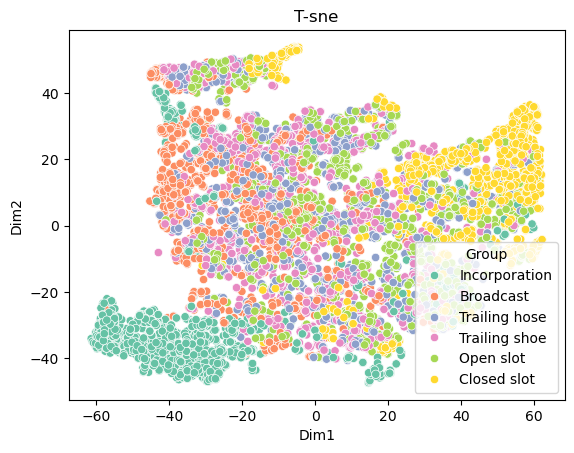

In [483]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="strategy", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

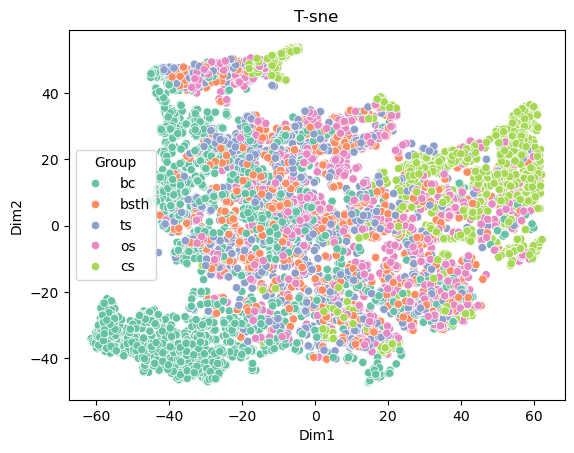

In [484]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="app.mthd", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

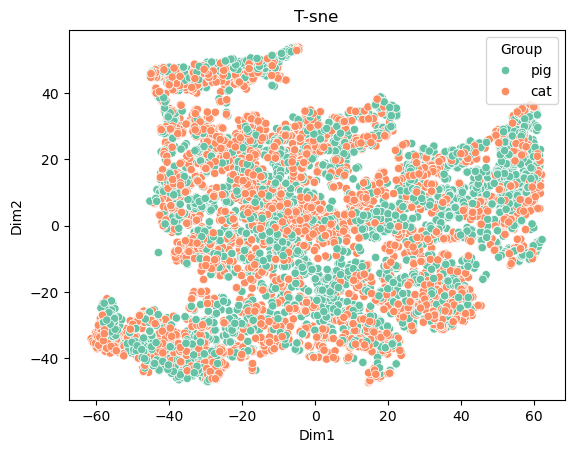

In [485]:
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="man.source", palette="Set2")

plt.title("T-sne")
plt.xlabel(f'Dim1')
plt.ylabel(f'Dim2')
plt.legend(title="Group")
plt.show()

# End